In [1]:
%cd "../.."

/home/ensai/projet-statistique-2022


In [6]:
from gensim import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.mixture import GaussianMixture as GMM
from sklearn.manifold import TSNE

import seaborn as sns
import plotly.express as px


from word_embedding.distance_wmd import *
import doc_embedding.moyenne as moyenne
from reduction_dim.correlation_matrix import *
import clustering.fit_clustering as CL 

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set(font_scale=1.5)  # crazy big
sns.set(font_scale=2)
sns.set_style("darkgrid")
meanprops={"marker":"o","markerfacecolor":"white","markeredgecolor":"black","markersize":"10"}

In [3]:
df_hdbscan_clustering = pd.read_csv("data/tuning/clustering/hdbscan.csv",sep=";")
df_hdbscan_clustering["clustering"] = "hdbscan"
df_hdbscan_clustering["K"]  = df_hdbscan_clustering["K"] - 1
df_kmeans_clustering = pd.read_csv("data/tuning/clustering/kmeans.csv",sep=";")
df_gmm_clustering = pd.read_csv("data/tuning/clustering/gmm.csv",sep=";")
df_gmm_clustering["clustering"] = "gmm"
df_clustering = pd.concat([df_hdbscan_clustering,df_kmeans_clustering,df_gmm_clustering])
df_clustering = df_clustering[(df_clustering["K"] >= 5) & (df_clustering["K"] <= 20)]

df_clustering["silhouette-DBCV"] = df_clustering[["silhouette","DBCV"]].apply(np.mean,axis=1)
df_clustering["DocEmbedding"] = df_clustering["docEmbedding"] +" - " + df_clustering["docEmbedding2"]
df_clustering = df_clustering.sort_values("DocEmbedding").reset_index()
df_clustering.head()

,index,voisinage,min_cluster_size,distance,K,silhouette,Cal-Harabasz,DBCV,non_classes,perplexity,...,docEmbedding2,clustering,initialisation,nb_iter,tolerance,val_obj,covariance,BIC,silhouette-DBCV,DocEmbedding
0,169,NaN,NaN,NaN,11,0.347343,12411.573947,-0.634164,NaN,100.0,...,TF,gmm,NaN,NaN,NaN,NaN,diag,169041.858173,-0.143411,Moyenne - TF
1,15576,19.0,100.0,euclidean,6,-0.059911,650.651622,-0.307294,2574.0,200.0,...,TF,hdbscan,NaN,NaN,NaN,NaN,NaN,NaN,-0.183603,Moyenne - TF
2,15579,14.0,150.0,euclidean,5,0.008991,735.245424,-0.310467,2674.0,200.0,...,TF,hdbscan,NaN,NaN,NaN,NaN,NaN,NaN,-0.150738,Moyenne - TF
3,15581,17.0,14.0,euclidean,20,-0.204722,286.311302,-0.313508,2400.0,200.0,...,TF,hdbscan,NaN,NaN,NaN,NaN,NaN,NaN,-0.259115,Moyenne - TF
4,15587,20.0,100.0,euclidean,6,-0.061481,651.489186,-0.326792,2402.0,200.0,...,TF,hdbscan,NaN,NaN,NaN,NaN,NaN,NaN,-0.194136,Moyenne - TF


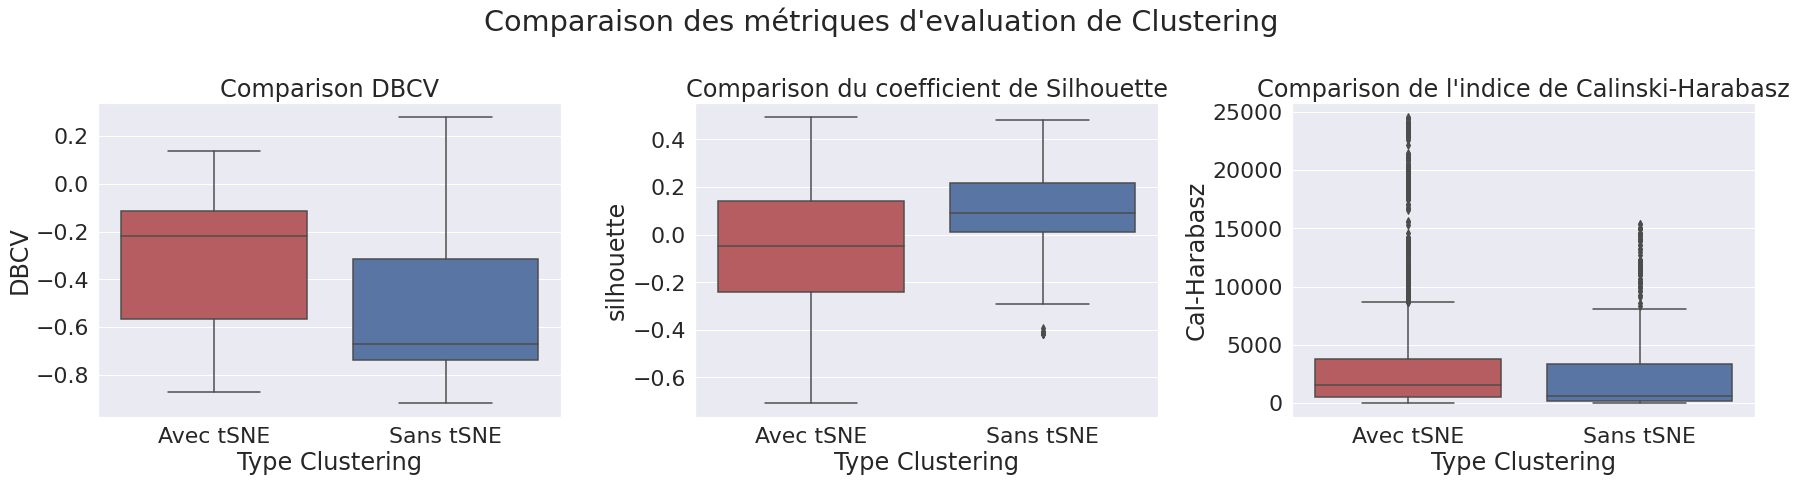

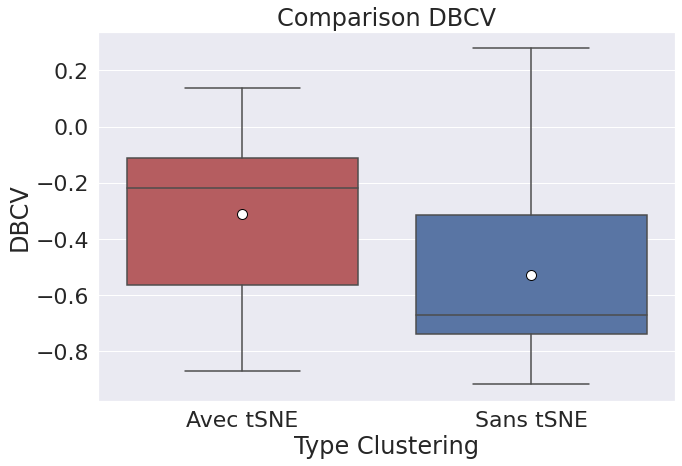

In [12]:
plt.figure(figsize = (25,7),tight_layout=True)
my_pal = {"Sans tSNE":"b","Avec tSNE":"r"}

df_clustering["Type Clustering"] = np.where(df_clustering["perplexity"].isna(),"Sans tSNE","Avec tSNE")
sns.boxplot(data=df_clustering.iloc[np.where(np.logical_or(df_clustering["perplexity"].isna(),df_clustering["perplexity"]==200))],y="DBCV",x="Type Clustering",palette={"Sans tSNE":"b","Avec tSNE":"r"},ax=plt.subplot(1,3,1,title="Comparison DBCV"))
sns.boxplot(data=df_clustering.iloc[np.where(np.logical_or(df_clustering["perplexity"].isna(),df_clustering["perplexity"]==200))],y="silhouette",x="Type Clustering",palette={"Sans tSNE":"b","Avec tSNE":"r"},ax=plt.subplot(1,3,2,title="Comparison du coefficient de Silhouette"))
sns.boxplot(data=df_clustering.iloc[np.where(np.logical_or(df_clustering["perplexity"].isna(),df_clustering["perplexity"]==200))],y="Cal-Harabasz",x="Type Clustering",palette={"Sans tSNE":"b","Avec tSNE":"r"},ax=plt.subplot(1,3,3,title="Comparison de l'indice de Calinski-Harabasz"))

plt.suptitle("Comparaison des métriques d'evaluation de Clustering")
plt.show()

plt.figure(figsize = (10,7),tight_layout=True)
sns.boxplot(data=df_clustering.iloc[np.where(np.logical_or(df_clustering["perplexity"].isna(),df_clustering["perplexity"]==200))],y="DBCV",x="Type Clustering",
palette={"Sans tSNE":"b","Avec tSNE":"r"},showmeans=True,meanprops=meanprops)
plt.title("Comparison DBCV")
plt.show()


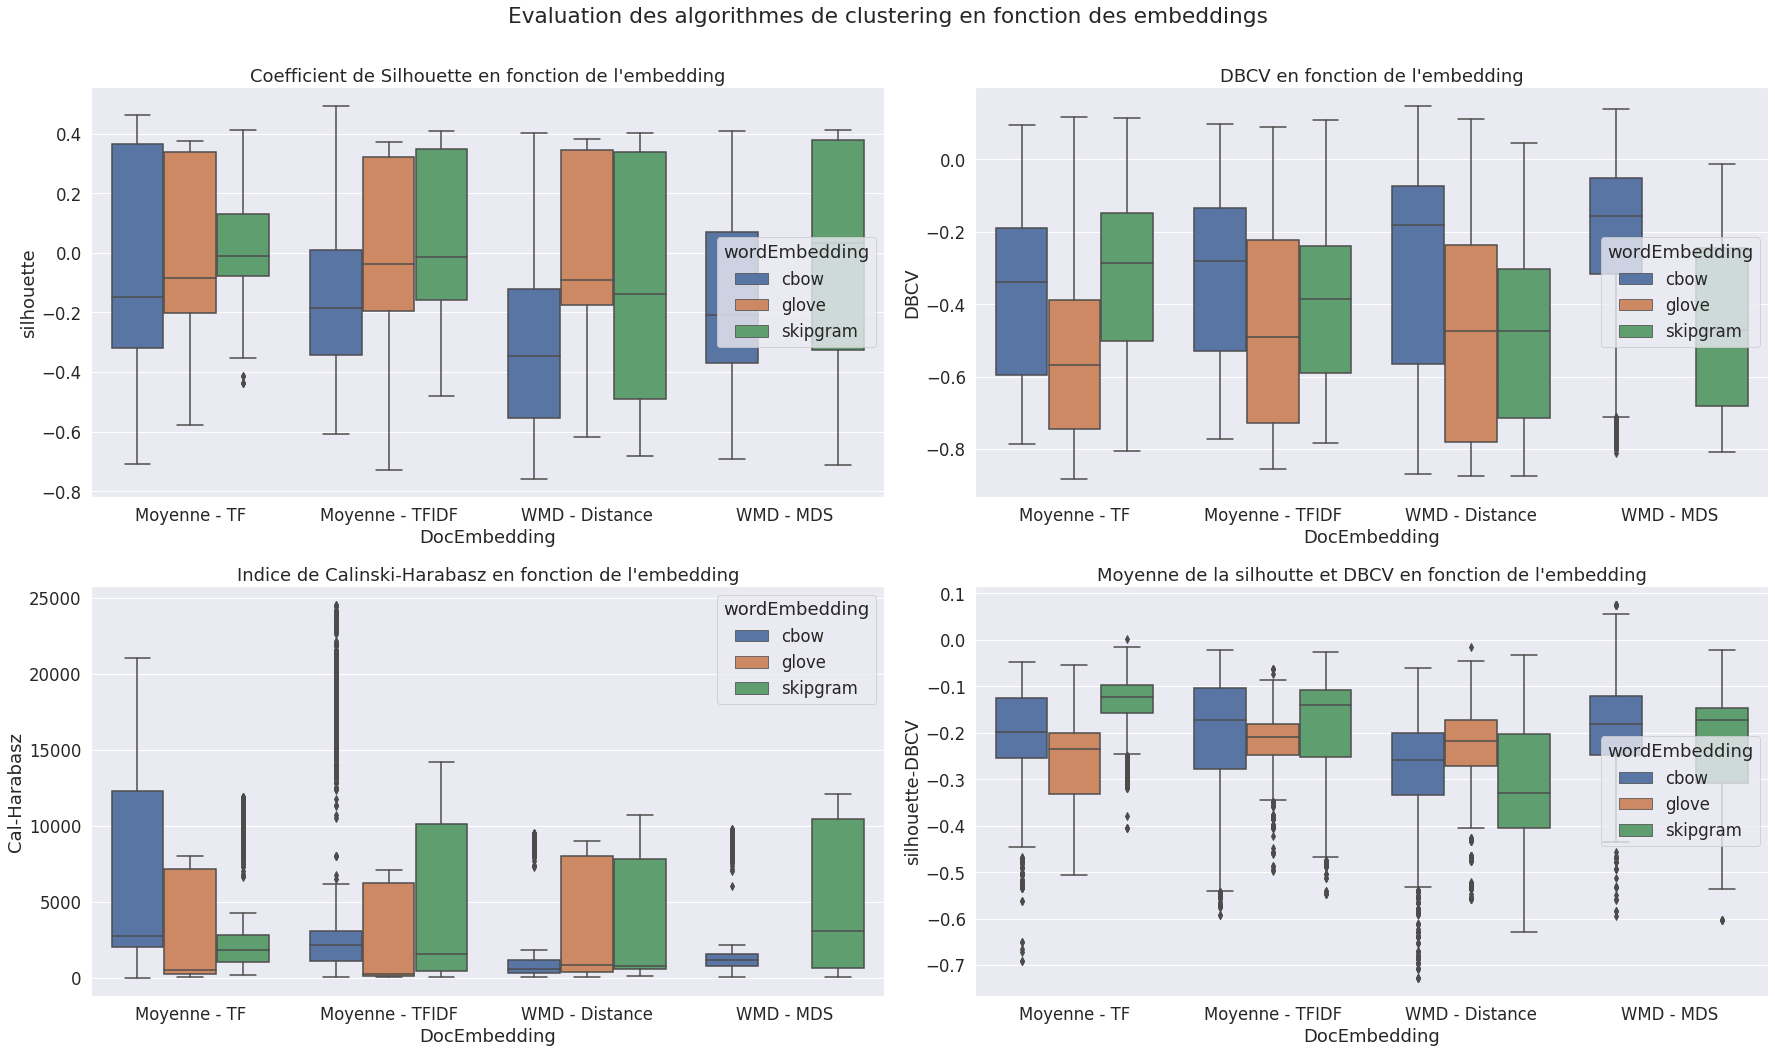

In [30]:
plt.figure(figsize = (25,15),tight_layout=True)
sns.boxplot(data=df_clustering,y="silhouette",x="DocEmbedding",hue="wordEmbedding", ax=plt.subplot(2,2,1,title=f"Coefficient de Silhouette en fonction de l'embedding"))
sns.boxplot(data=df_clustering,y="DBCV",x="DocEmbedding",hue="wordEmbedding", ax=plt.subplot(2,2,2,title=f"DBCV en fonction de l'embedding"))
sns.boxplot(data=df_clustering,y="Cal-Harabasz",x="DocEmbedding",hue="wordEmbedding", ax=plt.subplot(2,2,3,title=f"Indice de Calinski-Harabasz en fonction de l'embedding"))
sns.boxplot(data=df_clustering,y="silhouette-DBCV",x="DocEmbedding",hue="wordEmbedding", ax=plt.subplot(2,2,4,title=f"Moyenne de la silhoutte et DBCV en fonction de l'embedding"))

plt.suptitle("Evaluation des algorithmes de clustering en fonction des embeddings\n ")
plt.show()

# Scatter plot

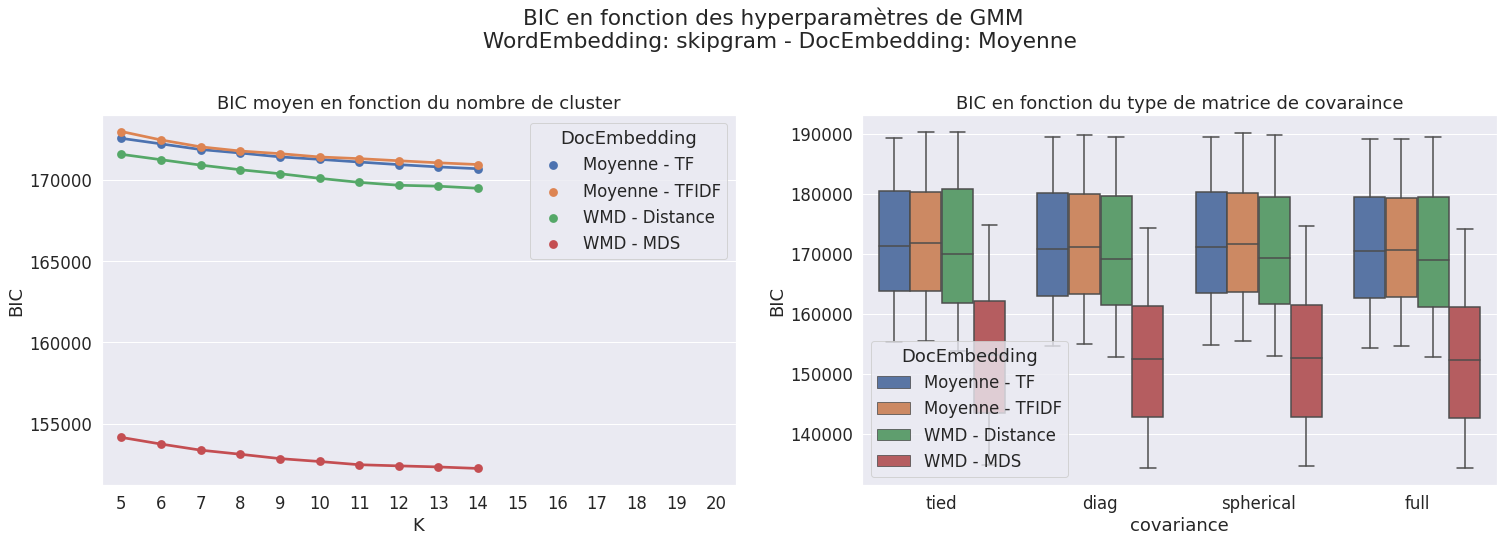

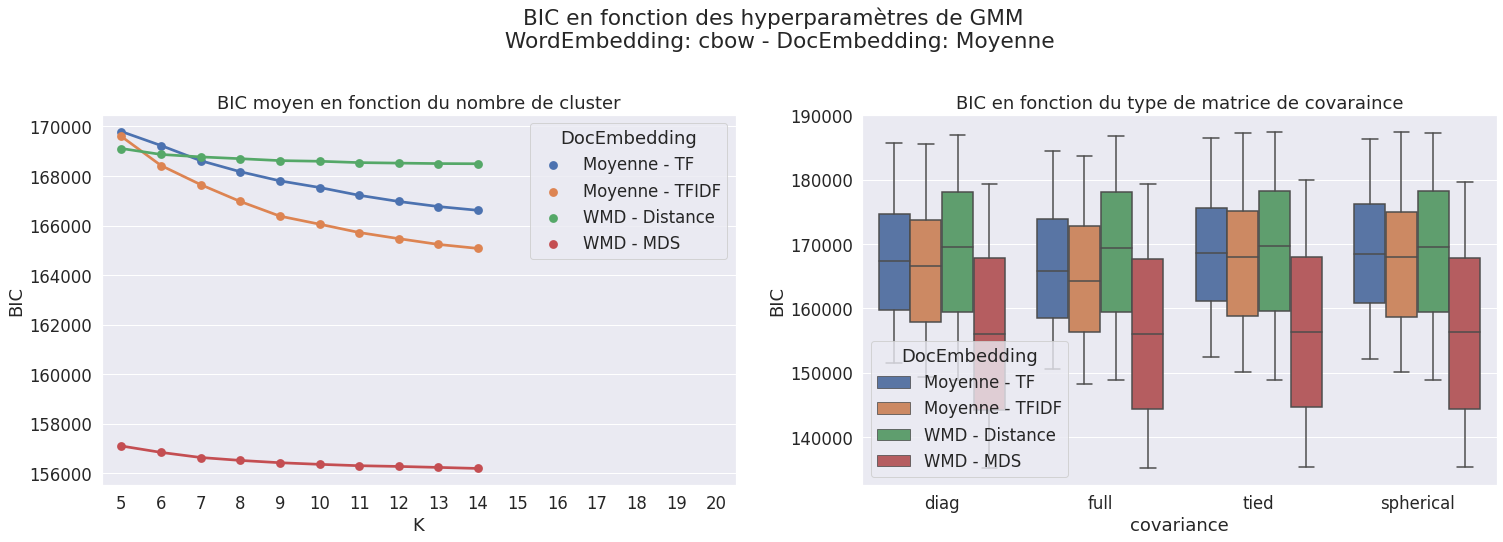

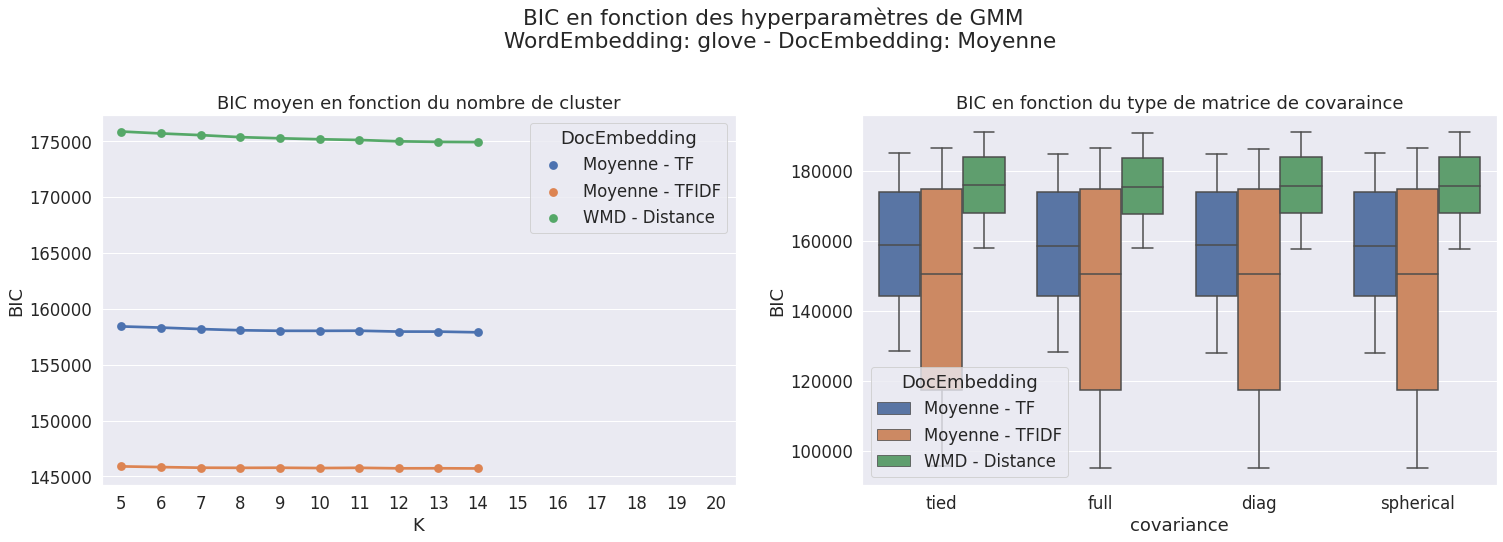

In [27]:

sns.set_style("darkgrid")
for modele in ["skipgram","cbow","glove"]:
    plt.figure(figsize = (25,15))
    sns.pointplot(data=df_clustering[df_clustering["wordEmbedding"]==modele],y="BIC",x="K",hue="DocEmbedding",ci=None,
        ax=plt.subplot(2,2,1,title=f"BIC moyen en fonction du nombre de cluster"))
    # sns.boxplot(data = df_gmm_moy[df_gmm_moy["wordEmbedding"]==modele],y="BIC",x="K",hue="docEmbedding2",ax=plt.subplot(2,2,1,title="K"))

    sns.boxplot(data=df_clustering[df_clustering["wordEmbedding"]==modele],y="BIC",x="covariance",hue="DocEmbedding",
        ax=plt.subplot(2,2,2,title=f"BIC en fonction du type de matrice de covaraince"))
    # sns.boxplot(data=df_gmm_moyTF,y="BIC",x="covariance",hue="wordEmbedding",ax=plt.subplot(2,2,2,title="covariance"))
    plt.suptitle(f"BIC en fonction des hyperparamètres de GMM \n WordEmbedding: {modele} - DocEmbedding: Moyenne")
    plt.show()

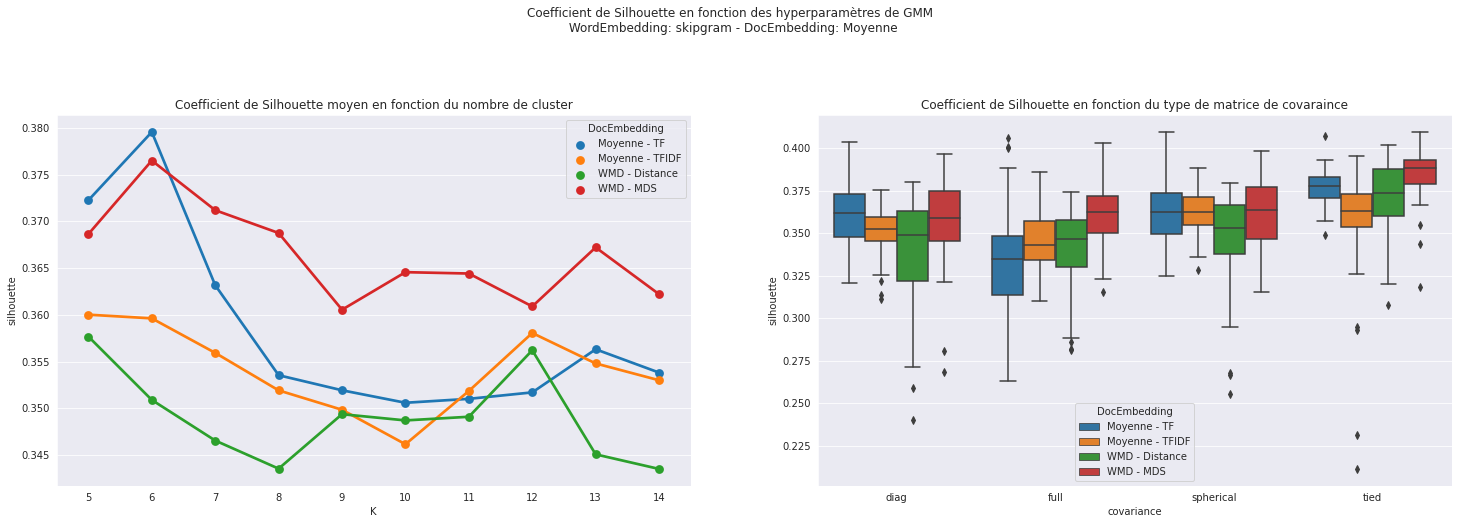

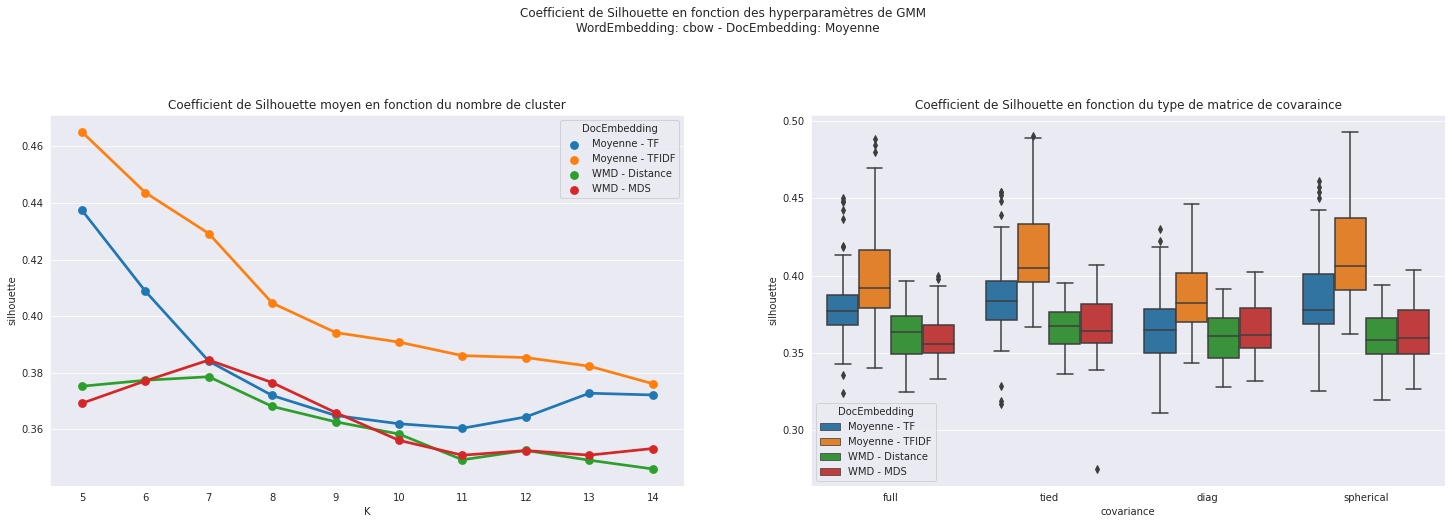

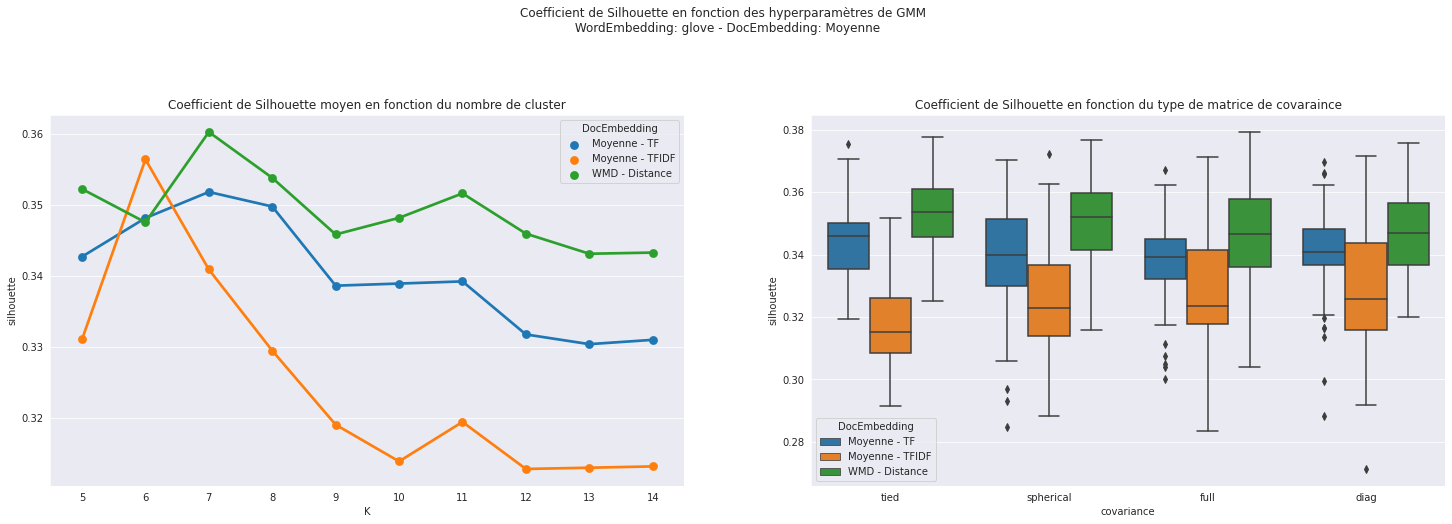

In [5]:
sns.set_style("darkgrid")
for modele in ["skipgram","cbow","glove"]:
    plt.figure(figsize = (25,15))
    sns.pointplot(data=df_clustering[df_clustering["wordEmbedding"]==modele],y="silhouette",x="K",hue="DocEmbedding",ci=None,
        ax=plt.subplot(2,2,1,title=f"Coefficient de Silhouette moyen en fonction du nombre de cluster"))
    # sns.boxplot(data = df_gmm_moy[df_gmm_moy["wordEmbedding"]==modele],y="BIC",x="K",hue="docEmbedding2",ax=plt.subplot(2,2,1,title="K"))

    sns.boxplot(data=df_clustering[df_clustering["wordEmbedding"]==modele],y="silhouette",x="covariance",hue="DocEmbedding",
        ax=plt.subplot(2,2,2,title=f"Coefficient de Silhouette en fonction du type de matrice de covaraince"))
    # sns.boxplot(data=df_gmm_moyTF,y="BIC",x="covariance",hue="wordEmbedding",ax=plt.subplot(2,2,2,title="covariance"))
    plt.suptitle(f"Coefficient de Silhouette en fonction des hyperparamètres de GMM \n WordEmbedding: {modele} - DocEmbedding: Moyenne")
    plt.show()

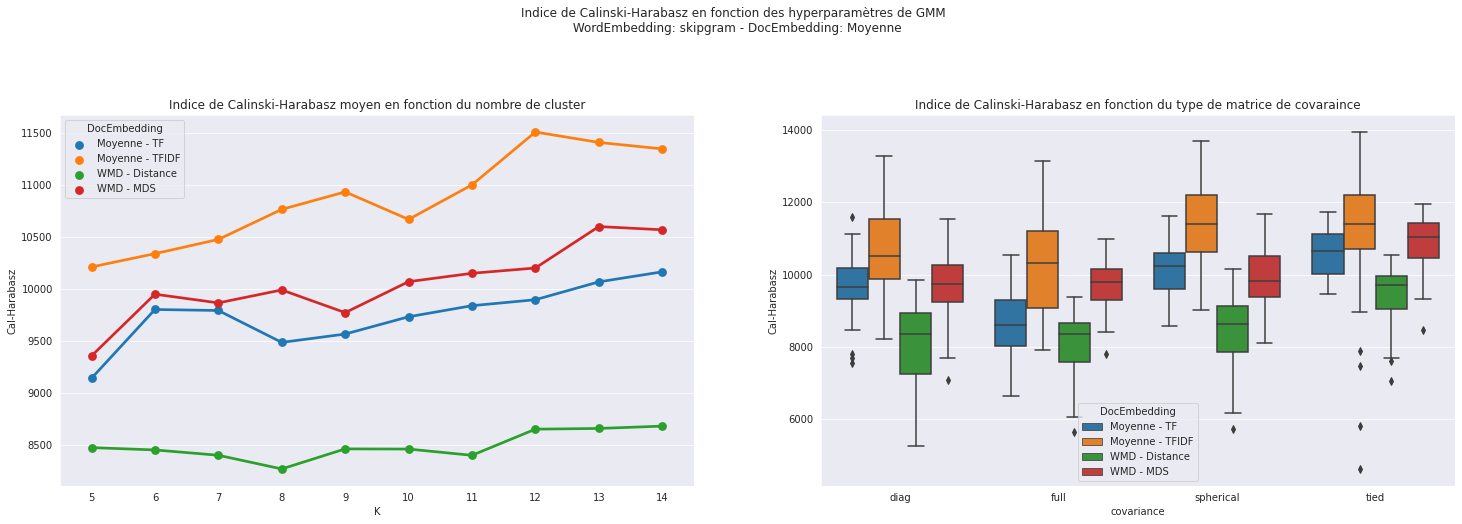

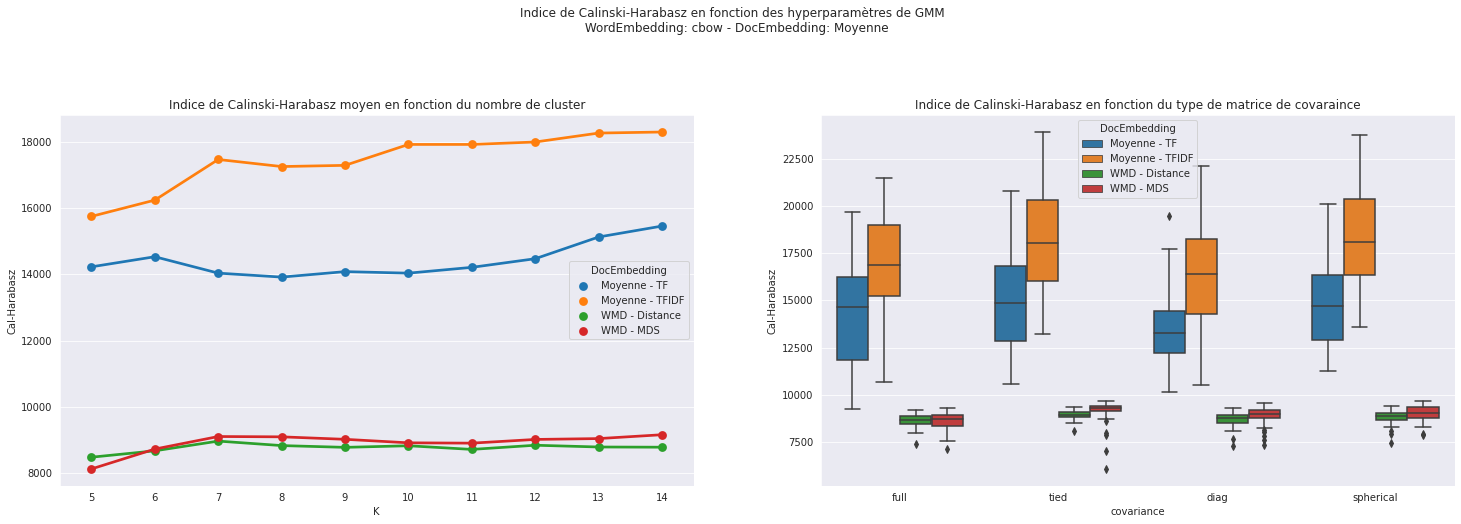

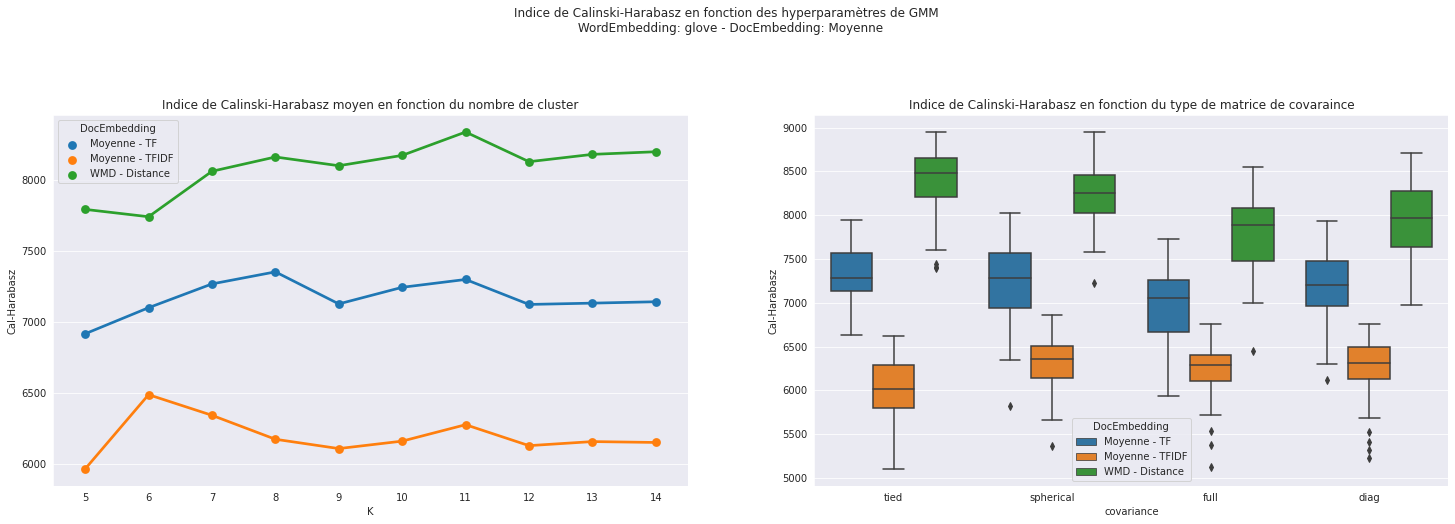

In [6]:
sns.set_style("darkgrid")
for modele in ["skipgram","cbow","glove"]:
    plt.figure(figsize = (25,15))
    sns.pointplot(data=df_clustering[df_clustering["wordEmbedding"]==modele],y="Cal-Harabasz",x="K",hue="DocEmbedding",ci=None,
        ax=plt.subplot(2,2,1,title=f"Indice de Calinski-Harabasz moyen en fonction du nombre de cluster"))
    # sns.boxplot(data = df_gmm_moy[df_gmm_moy["wordEmbedding"]==modele],y="BIC",x="K",hue="docEmbedding2",ax=plt.subplot(2,2,1,title="K"))

    sns.boxplot(data=df_clustering[df_clustering["wordEmbedding"]==modele],y="Cal-Harabasz",x="covariance",hue="DocEmbedding",
        ax=plt.subplot(2,2,2,title=f"Indice de Calinski-Harabasz en fonction du type de matrice de covaraince"))
    # sns.boxplot(data=df_gmm_moyTF,y="BIC",x="covariance",hue="wordEmbedding",ax=plt.subplot(2,2,2,title="covariance"))
    plt.suptitle(f"Indice de Calinski-Harabasz en fonction des hyperparamètres de GMM \n WordEmbedding: {modele} - DocEmbedding: Moyenne")
    plt.show()